In [1]:
from pathlib import Path

import os     
os.environ["PATH"] += os.pathsep + 'C:\\Users\\vines\\Anaconda3\\Library\\bin\\graphviz'

import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from mord import LogisticIT
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import plotDecisionTree, classificationSummary
from dmba import classificationSummary, gainsChart, liftChart

from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline


import statsmodels.api as sm


%matplotlib inline
import matplotlib.pylab as plt

In [2]:
# Create data frame for stroke data set. 
stroke_df = pd.read_csv('healthcarestokedataset.csv')


In [4]:
# Determine dimensions of dataframe. 
print('Patient Stroke Prediction Data Frame Dimentions:', stroke_df.shape)
stroke_df.head()

Patient Stroke Prediction Data Frame Dimentions: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<AxesSubplot:>

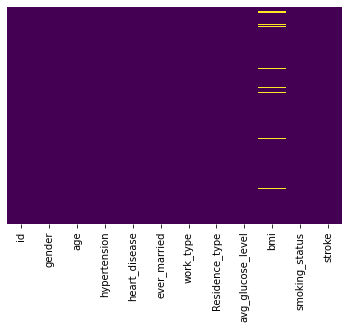

In [5]:
sns.heatmap(stroke_df.isnull(), cmap ='viridis', cbar=False, yticklabels=False)

<AxesSubplot:xlabel='stroke', ylabel='count'>

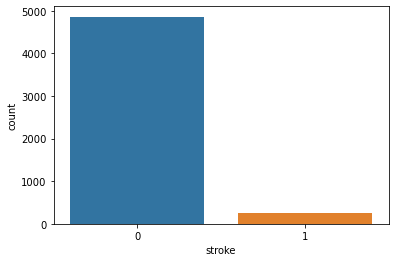

In [7]:
#check if the dataset is balanced (before undersampling - this shows that out dataset is highly imblanced - 4861 with no stroke and 249 with stroke
sns.countplot(x='stroke',data=stroke_df)

In [8]:
stroke_df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

<AxesSubplot:>

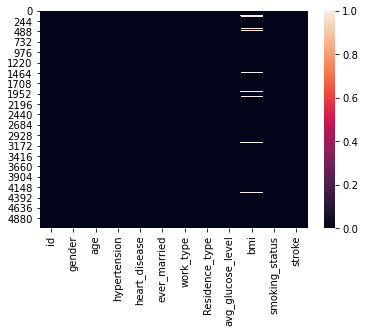

In [9]:
#heatmap for missing data indicates we have BMI missing
sns.heatmap(stroke_df.isnull())

In [10]:
#handle missing data by filling in with mean
stroke_df['bmi'].fillna(stroke_df['bmi'].mean(),inplace=True)

<AxesSubplot:>

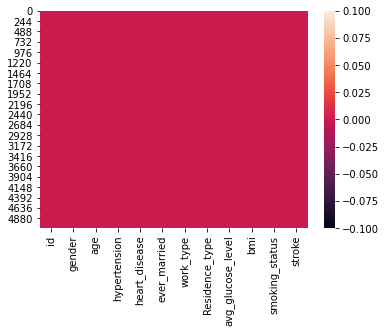

In [11]:
#Validate if the missing data is filled
sns.heatmap(stroke_df.isnull())

In [13]:
#check for categorical variables
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [14]:
Gen = pd.get_dummies(stroke_df['gender'], drop_first=True)
Married = pd.get_dummies(stroke_df['ever_married'], drop_first=True)
Work = pd.get_dummies(stroke_df['work_type'], drop_first=True)
Res = pd.get_dummies(stroke_df['Residence_type'], drop_first=True)
Smoking = pd.get_dummies(stroke_df['smoking_status'], drop_first=True)

In [15]:
stroke_df.drop(['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis=1, inplace=True)

In [16]:
stroke_df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,9046,67.0,0,1,228.69,36.600000,1
1,51676,61.0,0,0,202.21,28.893237,1
2,31112,80.0,0,1,105.92,32.500000,1
3,60182,49.0,0,0,171.23,34.400000,1
4,1665,79.0,1,0,174.12,24.000000,1


In [17]:
stroke_df = pd.concat([stroke_df, Gen, Married, Work, Res, Smoking], axis=1)

In [18]:
stroke_df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Male,Other,Yes,Never_worked,Private,Self-employed,children,Urban,formerly smoked,never smoked,smokes
0,9046,67.0,0,1,228.69,36.600000,1,1,0,1,0,1,0,0,1,1,0,0
1,51676,61.0,0,0,202.21,28.893237,1,0,0,1,0,0,1,0,0,0,1,0
2,31112,80.0,0,1,105.92,32.500000,1,1,0,1,0,1,0,0,0,0,1,0
3,60182,49.0,0,0,171.23,34.400000,1,0,0,1,0,1,0,0,1,0,0,1
4,1665,79.0,1,0,174.12,24.000000,1,0,0,1,0,0,1,0,0,0,1,0


In [19]:
stroke_df.drop(['id'], axis=1, inplace=True)

In [21]:
stroke_df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Male,Other,Yes,Never_worked,Private,Self-employed,children,Urban,formerly smoked,never smoked,smokes
0,67.0,0,1,228.69,36.600000,1,1,0,1,0,1,0,0,1,1,0,0
1,61.0,0,0,202.21,28.893237,1,0,0,1,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.500000,1,1,0,1,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.400000,1,0,0,1,0,1,0,0,1,0,0,1
4,79.0,1,0,174.12,24.000000,1,0,0,1,0,0,1,0,0,0,1,0


C:\Users\vines\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


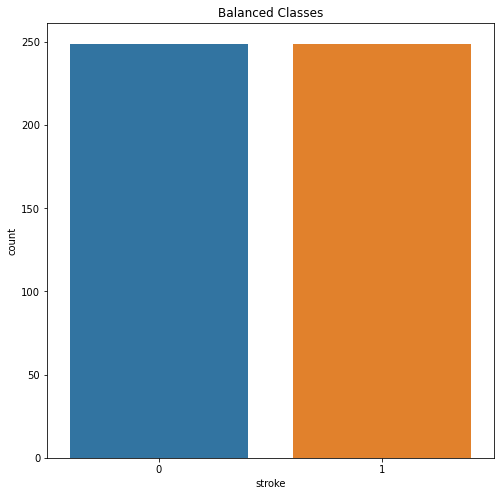

In [22]:
#We have an imbalanced data set here. To make it a balanced data set, we can make use of undersampling

# Shuffle the Dataset.
shuffled_df = stroke_df.sample(frac=1,random_state=4)

# Put all the yes stroke class in a separate dataset.
str_yes_df = shuffled_df.loc[shuffled_df['stroke'] == 1]

#Randomly select 249 observations from the no stroke (majority class)
str_no_df = shuffled_df.loc[shuffled_df['stroke'] == 0].sample(n=249,random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([str_yes_df, str_no_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('stroke', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

In [23]:
normalized_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 236 to 1255
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                498 non-null    float64
 1   hypertension       498 non-null    int64  
 2   heart_disease      498 non-null    int64  
 3   avg_glucose_level  498 non-null    float64
 4   bmi                498 non-null    float64
 5   stroke             498 non-null    int64  
 6   Male               498 non-null    uint8  
 7   Other              498 non-null    uint8  
 8   Yes                498 non-null    uint8  
 9   Never_worked       498 non-null    uint8  
 10  Private            498 non-null    uint8  
 11  Self-employed      498 non-null    uint8  
 12  children           498 non-null    uint8  
 13  Urban              498 non-null    uint8  
 14  formerly smoked    498 non-null    uint8  
 15  never smoked       498 non-null    uint8  
 16  smokes             498 

In [39]:
#run logical regression on the balanced dataset

# Create predictors X and outcome y variables - Logical regression
X = normalized_df.drop(columns=['stroke'])
y = normalized_df['stroke']

# Partition data into training (80% or 0.8) and validation(20% or 0.2)
# of the bank_df data frame.
train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                            test_size=0.2, random_state=1)

log_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
log_reg.fit(train_X, train_y)

# Show intercept and coefficients of the multiple predictors' logistic model.
print('Parameters of Logistic Regresion Model with Multiple Predictors')
print('Intercept:', np.round(log_reg.intercept_[0], decimals=3))
print('Coefficients for Predictors')
print(pd.DataFrame({'Coeff:': np.round(log_reg.coef_[0], decimals=3)}, 
                    index=X.columns).transpose())

Parameters of Logistic Regresion Model with Multiple Predictors
Intercept: -4.7
Coefficients for Predictors
         age  hypertension  heart_disease  avg_glucose_level    bmi  Male  \
Coeff:  0.07         0.711          0.583              0.005 -0.019 -0.04   

        Other    Yes  Never_worked  Private  Self-employed  children  Urban  \
Coeff:    0.0  0.138        -1.342    0.201          0.288      0.86 -0.068   

        formerly smoked  never smoked  smokes  
Coeff:            0.619        -0.074   0.768  


In [40]:
# Make predictions for validation set using multiple
# predictors logistic regression model. 

# Predict multiple predictors logistic model's results 
# (0 or 1) for validation set. 
log_pred = log_reg.predict(valid_X)

# Predict multiple predictors logistic model's probabilities 
# p(0) and p(1) for validation set.
log_prob = np.round(log_reg.predict_proba(valid_X), decimals=4)

# Create data frame to show multiple predictors logistic
# model resuts for validation set. 
log_result = pd.DataFrame({'Actual': valid_y, 
                    'Classification': log_pred,
                    'p(0)': [p[0] for p in log_prob],
                    'p(1)': [p[1] for p in log_prob]
})

print('Classification for Validation Partition')
pd.set_option('display.max_rows', 500)
print(log_result.head(10))


Classification for Validation Partition
      Actual  Classification    p(0)    p(1)
237        1               1  0.1235  0.8765
113        1               0  0.7550  0.2450
3158       0               0  0.9469  0.0531
5060       0               1  0.2014  0.7986
134        1               1  0.1498  0.8502
123        1               1  0.3023  0.6977
2941       0               0  0.9169  0.0831
666        0               1  0.2047  0.7953
1070       0               1  0.0949  0.9051
155        1               1  0.1091  0.8909


In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
accuracy_score(valid_y,log_pred)

0.76

In [37]:
#Confusion matrices for multiple predictors logistic model. 

# Identify and display confusion matrix for training partition. 
print('Training Partition')
classificationSummary(train_y, log_reg.predict(train_X))

# Identify and display confusion matrix for validation partition. 
print()
print('Validation Partition')
classificationSummary(valid_y, log_reg.predict(valid_X))

Training Partition
Confusion Matrix (Accuracy 0.7714)

       Prediction
Actual   0   1
     0 139  55
     1  36 168

Validation Partition
Confusion Matrix (Accuracy 0.7600)

       Prediction
Actual  0  1
     0 37 18
     1  6 39


In [51]:
#Decision Tree
df_train = normalized_df.drop(['stroke'],axis=1)
df_class=normalized_df['stroke']
xtrain,xtest,ytrain,ytest = train_test_split(df_train,df_class,test_size=0.2, random_state=100)
tree = DecisionTreeClassifier(random_state=100)
tree.fit(xtrain,ytrain)

DecisionTreeClassifier(random_state=100)

In [52]:
print(f'Accuracy : {tree.score(xtest,ytest)}')

Accuracy : 0.69


In [53]:
#Confusion matrices for multiple predictors decision tree model. 

# Identify and display confusion matrix for training partition. 
print('Training Partition')
classificationSummary(ytrain, tree.predict(xtrain))

# Identify and display confusion matrix for validation partition. 
print()
print('Validation Partition')
classificationSummary(ytest, tree.predict(xtest))

Training Partition
Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual   0   1
     0 195   0
     1   0 203

Validation Partition
Confusion Matrix (Accuracy 0.6900)

       Prediction
Actual  0  1
     0 40 14
     1 17 29


In [54]:
#random forest
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(xtrain, ytrain)

RandomForestClassifier()

In [60]:
#Confusion matrices for multiple predictors random forest model. 

# Identify and display confusion matrix for training partition. 
print('Training Partition')
classificationSummary(ytrain, RF.predict(xtrain))

# Identify and display confusion matrix for validation partition. 
print()
print('Validation Partition')
classificationSummary(ytest, RF.predict(xtest))

Training Partition
Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual   0   1
     0 195   0
     1   0 203

Validation Partition
Confusion Matrix (Accuracy 0.7600)

       Prediction
Actual  0  1
     0 41 13
     1 11 35


In [62]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(xtrain, ytrain)

KNeighborsClassifier()

In [63]:
#Confusion matrices for multiple predictors knn model. 

# Identify and display confusion matrix for training partition. 
print('Training Partition')
classificationSummary(ytrain, knn.predict(xtrain))

# Identify and display confusion matrix for validation partition. 
print()
print('Validation Partition')
classificationSummary(ytest, knn.predict(xtest))

Training Partition
Confusion Matrix (Accuracy 0.8040)

       Prediction
Actual   0   1
     0 146  49
     1  29 174

Validation Partition
Confusion Matrix (Accuracy 0.7300)

       Prediction
Actual  0  1
     0 39 15
     1 12 34


In [64]:
from sklearn.svm import SVC
classifier = SVC(random_state = 0, kernel = 'linear')
classifier.fit(xtrain, ytrain)

SVC(kernel='linear', random_state=0)

In [65]:
#Confusion matrices for multiple predictors svm model. 

# Identify and display confusion matrix for training partition. 
print('Training Partition')
classificationSummary(ytrain, classifier.predict(xtrain))

# Identify and display confusion matrix for validation partition. 
print()
print('Validation Partition')
classificationSummary(ytest, classifier.predict(xtest))

Training Partition
Confusion Matrix (Accuracy 0.7538)

       Prediction
Actual   0   1
     0 131  64
     1  34 169

Validation Partition
Confusion Matrix (Accuracy 0.7800)

       Prediction
Actual  0  1
     0 41 13
     1  9 37
